In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif, SelectKBest
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
# Load data
df = pd.read_csv('UTSClustering.csv', encoding='ISO-8859-1')

In [60]:
# Load data
df = pd.read_csv('UTSClustering.csv', encoding='ISO-8859-1')

# Fungsi pembersihan data
def clean_data(df):
    # Handle missing values
    df = df.dropna()
    # Remove duplicates
    df = df.drop_duplicates()
    # Hapus kolom konstan/quasi-konstan
    constant_cols = [col for col in df.columns if df[col].nunique() == 1]
    quasi_constant = [col for col in df.columns if (df[col].value_counts(normalize=True).max() > 0.95)]
    df = df.drop(columns=constant_cols + quasi_constant)
    # Ekstrak fitur dari tanggal
    if 'InvoiceDate' in df.columns:
        df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
        df['InvoiceDay'] = df['InvoiceDate'].dt.day
        df['InvoiceMonth'] = df['InvoiceDate'].dt.month
    # Total price
    if 'Quantity' in df.columns and 'UnitPrice' in df.columns:
        df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
        df['UnitPrice'] = pd.to_numeric(df['UnitPrice'], errors='coerce')
        df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
        # Hapus baris dengan nilai invalid
        df = df.dropna(subset=['TotalPrice'])
    
    return df

cleaned_df = clean_data(df)

In [61]:
def feature_selection(df, target_col=None):
    # Hapus kolom non-numerik sebelum seleksi fitur
    df_numeric = df.select_dtypes(include=['int64', 'float64'])
    
    # Hapus kolom duplikat
    df_numeric = df_numeric.loc[:, ~df_numeric.columns.duplicated()]
    
    # Hapus kolom dengan korelasi tinggi (>0.9)
    corr_matrix = df_numeric.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr = [col for col in upper.columns if any(upper[col] > 0.9)]
    df_numeric = df_numeric.drop(columns=high_corr)
    
    # Jika ada target, tambahkan kembali kolom target ke df_numeric
    if target_col and target_col in df.columns:
        df_numeric[target_col] = df[target_col]
    
    # Gunakan Mutual Information/Chi-Square/ANOVA (jika ada target)
    if target_col and target_col in df_numeric.columns:
        X = df_numeric.drop(columns=[target_col])
        y = df_numeric[target_col]
        
        # Mutual Information
        mi = mutual_info_classif(X, y)
        mi_features = X.columns[mi > 0.01]  # Threshold arbitrer
        
        # Chi-Square
        chi, _ = chi2(X, y)
        chi_features = X.columns[chi > np.mean(chi)]
        
        # ANOVA
        f, _ = f_classif(X, y)
        anova_features = X.columns[f > np.mean(f)]
        
        # Gabungkan fitur terpilih
        selected_features = list(set(mi_features) | set(chi_features) | set(anova_features))
        df_numeric = df_numeric[selected_features + [target_col]]
    
    return df_numeric

# Asumsikan kolom target 'Target' ada (sesuaikan dengan dataset)
cleaned_df = feature_selection(cleaned_df, target_col='Target')

In [62]:
# Fungsi rekayasa fitur
def feature_engineering(df, max_categories=20):
    # Encoding kategorikal
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    
    # Transformasi log untuk fitur numerik positif
# Transformasi log untuk kolom numerik positif
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in numerical_cols:
        if df[col].min() <= 0:
            # Ganti nilai <= 0 dengan 0.001 untuk hindari log(0)
            df[col] = df[col].apply(lambda x: 0.001 if x <= 0 else x)
        df[f'log_{col}'] = np.log1p(df[col])
    
    # Standardisasi
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df[numerical_cols])
    df_scaled = pd.DataFrame(scaled_features, columns=[f'scaled_{col}' for col in numerical_cols])
    
    # Gabungkan dan hapus kolom asli
    df = pd.concat([df.drop(columns=numerical_cols), df_scaled], axis=1)
    
    # Hapus baris dengan NaN (jika ada)
    df = df.dropna()
    
    return df

engineered_df = feature_engineering(cleaned_df)

In [63]:
# Cek NaN setelah feature_engineering
print("Jumlah NaN dalam engineered_df:", engineered_df.isna().sum().sum())

# Jika masih ada NaN, isi dengan mean kolom
if engineered_df.isna().sum().sum() > 0:
    engineered_df = engineered_df.fillna(engineered_df.mean())

# Reduksi dimensi dengan PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(engineered_df.select_dtypes(include='number'))

Jumlah NaN dalam engineered_df: 0


In [66]:
# Subsampling 10% data untuk semua model
sample_df = engineered_df.sample(frac=0.1, random_state=42)
X_pca = PCA(n_components=2).fit_transform(sample_df.select_dtypes(include='number'))

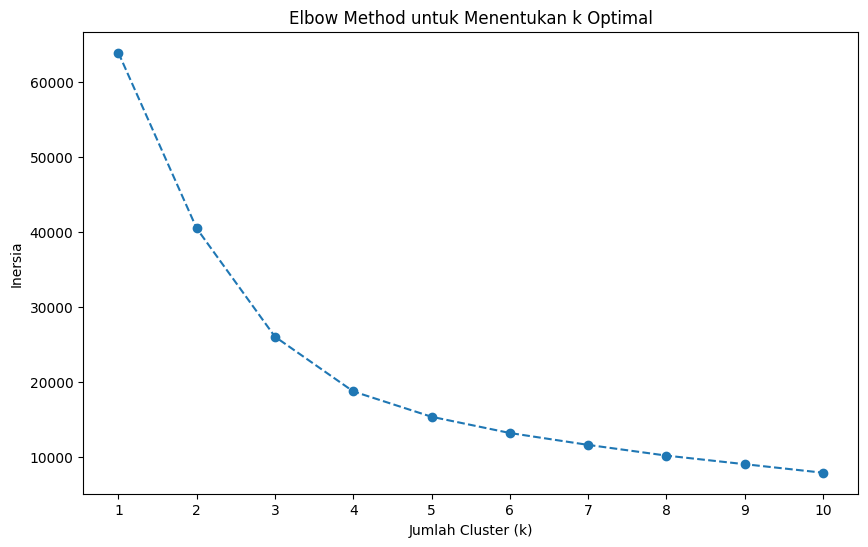

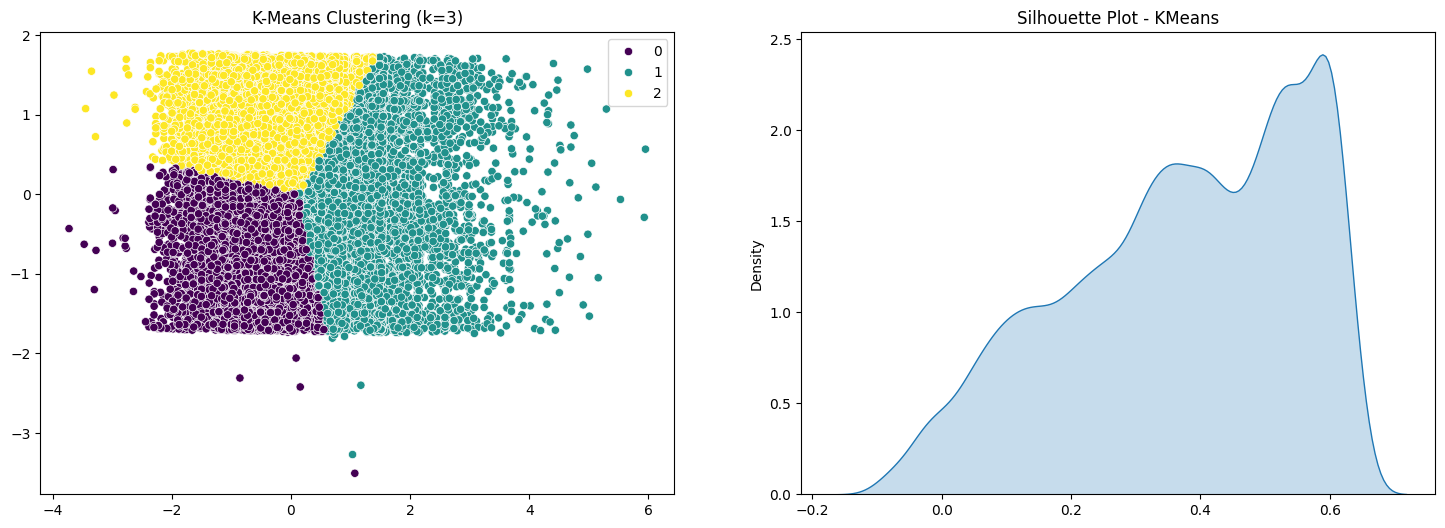

K-Means Metrics: {'Silhouette': np.float64(0.3734633127273781), 'Davies-Bouldin': np.float64(0.8748129999447389), 'Calinski-Harabasz': np.float64(21463.39247623749)}


In [ ]:
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inersia')
plt.title('Elbow Method untuk Menentukan k Optimal')
plt.xticks(k_range)
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42)  # Sesuaikan k sesuai elbow point
kmeans_clusters = kmeans.fit_predict(X_pca)

# Hitung metrik
kmeans_metrics = {
    'Silhouette': silhouette_score(X_pca, kmeans_clusters),
    'Davies-Bouldin': davies_bouldin_score(X_pca, kmeans_clusters),
    'Calinski-Harabasz': calinski_harabasz_score(X_pca, kmeans_clusters)
}

# Visualisasi
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Scatter Plot
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=kmeans_clusters, palette='viridis', ax=ax[0])
ax[0].set_title('K-Means Clustering (k=3)')

# Silhouette Plot
silhouette_vals = silhouette_samples(X_pca, kmeans_clusters)
sns.kdeplot(silhouette_vals, fill=True, ax=ax[1])
ax[1].set_title('Silhouette Plot - KMeans')
plt.show()

print("K-Means Metrics:", kmeans_metrics)

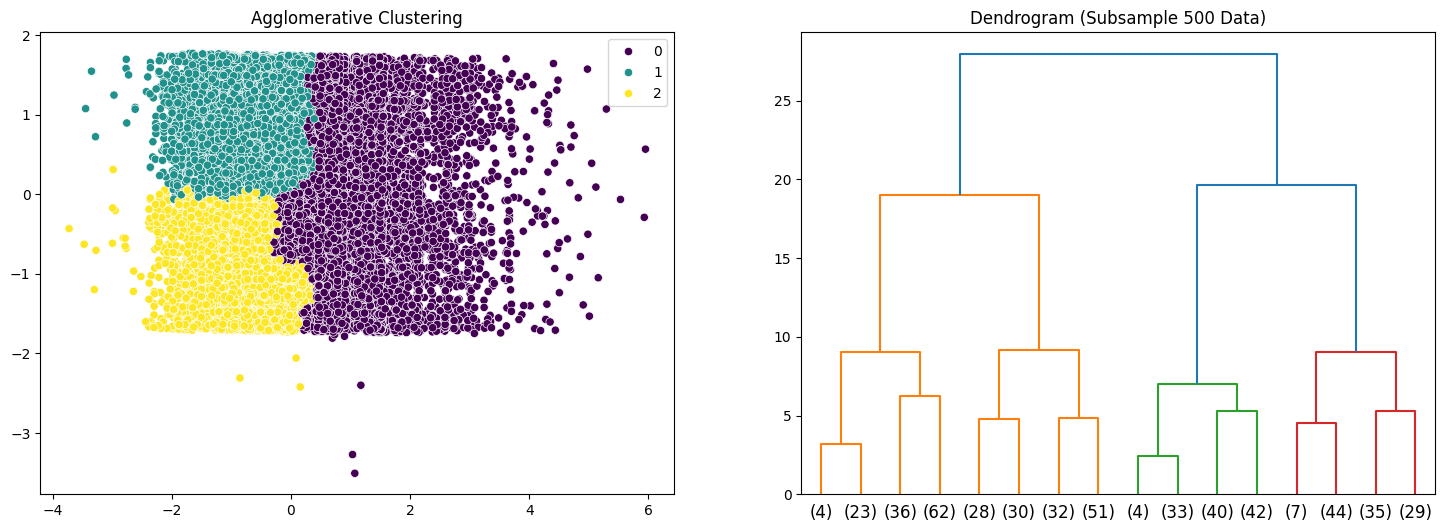

Agglomerative Metrics: {'Silhouette': np.float64(0.3385068419572568), 'Davies-Bouldin': np.float64(0.9058017032824209), 'Calinski-Harabasz': np.float64(18752.585440436735)}


In [69]:
try:
    agg = AgglomerativeClustering(n_clusters=3)
    agg_clusters = agg.fit_predict(X_pca)
    
    # Hitung metrik
    agg_metrics = {
        'Silhouette': silhouette_score(X_pca, agg_clusters),
        'Davies-Bouldin': davies_bouldin_score(X_pca, agg_clusters),
        'Calinski-Harabasz': calinski_harabasz_score(X_pca, agg_clusters)
    }
    
    # Visualisasi
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    
    # Scatter Plot
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=agg_clusters, palette='viridis', ax=ax[0])
    ax[0].set_title('Agglomerative Clustering')
    
    # Dendrogram (Subsample 500 data)
    sample_idx = np.random.choice(len(X_pca), 500, replace=False)
    linked = linkage(X_pca[sample_idx], 'ward')
    dendrogram(linked, ax=ax[1], truncate_mode='level', p=3)
    ax[1].set_title('Dendrogram (Subsample 500 Data)')
    plt.show()
    
    print("Agglomerative Metrics:", agg_metrics)
    
except MemoryError:
    print("Agglomerative Clustering tidak dapat dijalankan: MemoryError")

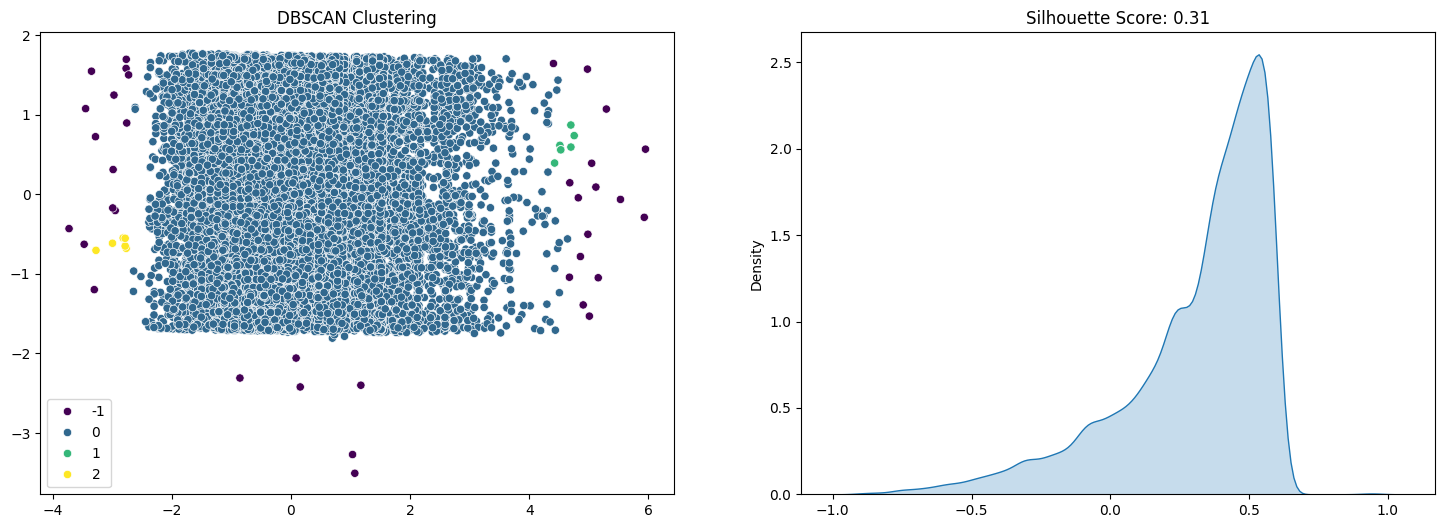

DBSCAN Metrics: {'Silhouette': np.float64(0.30958443914324024), 'Davies-Bouldin': np.float64(2.8356477942594207), 'Calinski-Harabasz': np.float64(42.1527829813526)}


In [75]:
dbscan = DBSCAN(eps=0.3, min_samples=5)  # Parameter disesuaikan
dbscan_clusters = dbscan.fit_predict(X_pca)

# Hitung metrik
if len(np.unique(dbscan_clusters)) > 1:
    dbscan_metrics = {
        'Silhouette': silhouette_score(X_pca, dbscan_clusters),
        'Davies-Bouldin': davies_bouldin_score(X_pca, dbscan_clusters),
        'Calinski-Harabasz': calinski_harabasz_score(X_pca, dbscan_clusters)
    }
else:
    dbscan_metrics = {'Error': 'Semua data dalam 1 cluster'}

# Visualisasi
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Scatter Plot
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=dbscan_clusters, palette='viridis', ax=ax[0])
ax[0].set_title('DBSCAN Clustering')

# Silhouette Plot
if len(np.unique(dbscan_clusters)) > 1:
    silhouette_vals = silhouette_samples(X_pca, dbscan_clusters)
    sns.kdeplot(silhouette_vals, fill=True, ax=ax[1])
    ax[1].set_title(f'Silhouette Score: {dbscan_metrics.get("Silhouette", 0):.2f}')
else:
    ax[1].axis('off')
plt.show()

print("DBSCAN Metrics:", dbscan_metrics)

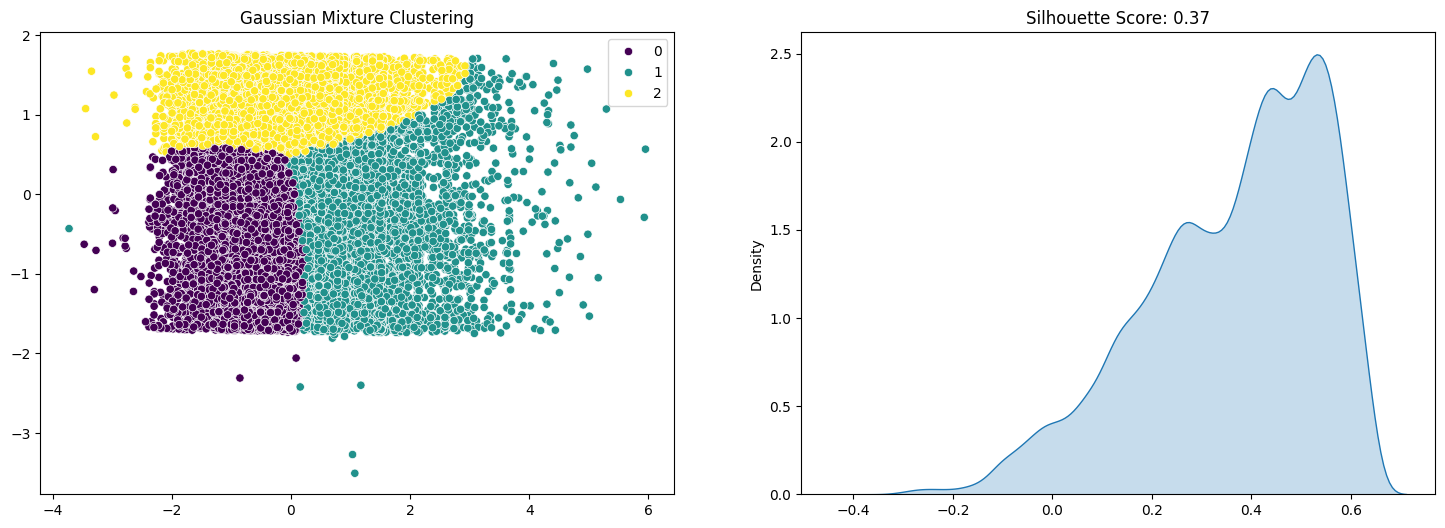

Gaussian Mixture Metrics: {'Silhouette': np.float64(0.3650876631596356), 'Davies-Bouldin': np.float64(0.9000132681214552), 'Calinski-Harabasz': np.float64(19646.186658428538)}


In [76]:
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_clusters = gmm.fit_predict(X_pca)

# Hitung metrik
gmm_metrics = {
    'Silhouette': silhouette_score(X_pca, gmm_clusters),
    'Davies-Bouldin': davies_bouldin_score(X_pca, gmm_clusters),
    'Calinski-Harabasz': calinski_harabasz_score(X_pca, gmm_clusters)
}

# Visualisasi
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Scatter Plot
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=gmm_clusters, palette='viridis', ax=ax[0])
ax[0].set_title('Gaussian Mixture Clustering')

# Silhouette Plot
silhouette_vals = silhouette_samples(X_pca, gmm_clusters)
sns.kdeplot(silhouette_vals, fill=True, ax=ax[1])
ax[1].set_title(f'Silhouette Score: {gmm_metrics["Silhouette"]:.2f}')
plt.show()

print("Gaussian Mixture Metrics:", gmm_metrics)

In [79]:
try:
    spectral = SpectralClustering(n_clusters=3, random_state=42)
    spectral_clusters = spectral.fit_predict(X_pca)
    
    # Hitung metrik
    spectral_metrics = {
        'Silhouette': silhouette_score(X_pca, spectral_clusters),
        'Davies-Bouldin': davies_bouldin_score(X_pca, spectral_clusters),
        'Calinski-Harabasz': calinski_harabasz_score(X_pca, spectral_clusters)
    }
    
    # Visualisasi
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=spectral_clusters, palette='viridis', ax=ax[0])
    ax[0].set_title('Spectral Clustering')
    
    silhouette_vals = silhouette_samples(X_pca, spectral_clusters)
    sns.kdeplot(silhouette_vals, fill=True, ax=ax[1])
    ax[1].set_title(f'Silhouette Score: {spectral_metrics["Silhouette"]:.2f}')
    plt.show()
    
    print("Spectral Clustering Metrics:", spectral_metrics)
    
except MemoryError:
    spectral_metrics = {'Error': 'MemoryError'}
    print("Spectral Clustering tidak dapat dijalankan: MemoryError")
except Exception as e:
    spectral_metrics = {'Error': str(e)}
    print(f"Error: {str(e)}")
finally:
    print("Spectral Clustering Metrics:", spectral_metrics)

Spectral Clustering tidak dapat dijalankan: MemoryError
Spectral Clustering Metrics: {'Error': 'MemoryError'}


In [88]:
# Tampilkan semua model dengan status lengkap
print("\n" + "="*60)
print("LAPORAN LENGKAP MODEL CLUSTERING")
print("="*60)
print(f"{'Model':<15} | {'Silhouette':<10} | {'Davies-Bouldin':<15} | {'Calinski-Harabasz':<15} | Status")
print("-"*80)

for model, metrics in all_metrics.items():
    if 'Error' in metrics.values():
        silhouette = 'Error' if 'Silhouette' not in metrics else f"{metrics['Silhouette']:.3f}"
        db = 'Error' if 'Davies-Bouldin' not in metrics else f"{metrics['Davies-Bouldin']:.3f}"
        ch = 'Error' if 'Calinski-Harabasz' not in metrics else f"{metrics['Calinski-Harabasz']:.3f}"
        status = list(metrics.values())[0] if 'Error' in metrics else 'Valid'
    else:
        silhouette = f"{metrics['Silhouette']:.3f}"
        db = f"{metrics['Davies-Bouldin']:.3f}"
        ch = f"{metrics['Calinski-Harabasz']:.3f}"
        status = 'Valid'
    
    print(f"{model:<15} | {silhouette:<10} | {db:<15} | {ch:<15} | {status}")

# Tentukan model terbaik hanya dari yang valid
valid_models = [
    (model, metrics) 
    for model, metrics in all_metrics.items() 
    if 'Silhouette' in metrics and 'Davies-Bouldin' in metrics and 'Calinski-Harabasz' in metrics
]

if valid_models:
    best_model = max(
        valid_models,
        key=lambda x: (x[1]['Silhouette'], -x[1]['Davies-Bouldin'], x[1]['Calinski-Harabasz'])
    )
    print("\n" + "="*60)
    print(f"MODEL TERBAIK: {best_model[0]}")
    print("="*60)
    print("Kriteria:")
    print(f"- Silhouette Score Tertinggi   : {best_model[1]['Silhouette']:.3f}")
    print(f"- Davies-Bouldin Index Terendah: {best_model[1]['Davies-Bouldin']:.3f}")
    print(f"- Calinski-Harabasz Tertinggi  : {best_model[1]['Calinski-Harabasz']:.3f}")
else:
    print("\n⚠️ Tidak ada model yang memenuhi kriteria evaluasi lengkap!")


LAPORAN LENGKAP MODEL CLUSTERING
Model           | Silhouette | Davies-Bouldin  | Calinski-Harabasz | Status
--------------------------------------------------------------------------------
KMeans          | 0.373      | 0.875           | 21463.392       | Valid
Agglomerative   | 0.339      | 0.906           | 18752.585       | Valid
DBSCAN          | 0.310      | 2.836           | 42.153          | Valid
GaussianMixture | 0.365      | 0.900           | 19646.187       | Valid


KeyError: 'Silhouette'

Penjelasan Model Clustering
1. KMeans
KMeans adalah algoritma clustering yang membagi data ke dalam K kelompok berdasarkan jarak ke pusat klaster (centroid). Algoritma ini bekerja dengan cara menginisialisasi beberapa centroid, mengelompokkan data ke centroid terdekat, lalu memperbarui posisi centroid hingga konvergen. KMeans efisien dan cepat, namun bekerja optimal hanya jika data memiliki bentuk klaster yang bulat (spherical) dan ukuran yang relatif seragam. Ia juga sensitif terhadap pemilihan jumlah klaster dan outlier.

2. Agglomerative Clustering
Agglomerative Clustering merupakan metode hierarchical clustering yang bekerja secara bottom-up, di mana setiap data awalnya dianggap sebagai klaster sendiri, lalu secara bertahap digabungkan berdasarkan kedekatan hingga membentuk satu klaster besar. Kelebihannya adalah tidak perlu menentukan jumlah klaster di awal (meskipun bisa dipangkas kemudian), dan dapat menangani bentuk klaster yang tidak beraturan. Namun, metode ini cenderung lebih lambat dan tidak skalabel untuk dataset besar.

3. DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
DBSCAN membentuk klaster berdasarkan kepadatan lokal. Titik-titik yang memiliki cukup banyak tetangga dalam radius tertentu (epsilon) akan membentuk inti klaster, sedangkan titik yang jauh dianggap sebagai noise. DBSCAN sangat baik untuk menangkap klaster dengan bentuk arbitrer dan menangani outlier secara alami. Namun, performanya sangat sensitif terhadap pemilihan parameter epsilon dan MinPts, serta kurang cocok untuk data berdimensi tinggi.

4. Gaussian Mixture Model (GMM)
Gaussian Mixture Model adalah pendekatan probabilistik untuk clustering, di mana setiap klaster dianggap sebagai distribusi Gaussian (normal) dan data memiliki probabilitas keanggotaan terhadap tiap klaster. Tidak seperti KMeans yang bersifat keras (hard clustering), GMM menghasilkan soft clustering, artinya satu data bisa memiliki probabilitas berbeda untuk setiap klaster. GMM lebih fleksibel dalam menangkap bentuk distribusi elips dan tidak mengasumsikan bentuk simetris seperti KMeans.

5. Spectral Clustering
Spectral Clustering memanfaatkan teori spektrum graf (eigenvalue dari matriks similaritas) untuk melakukan clustering pada data, terutama ketika bentuk klaster tidak bisa ditangkap oleh algoritma seperti KMeans. Ia bekerja dengan membentuk matriks kedekatan antar titik, mengubahnya menjadi bentuk spektral, lalu melakukan clustering (biasanya KMeans) di ruang eigenspace. Algoritma ini efektif untuk data dengan struktur kompleks, tetapi memerlukan perhitungan eigenvalue yang mahal dan tidak ideal untuk dataset besar.

**SOAL**
1. Jika algoritma K-Means menghasilkan nilai silhouette score rendah (0.3) meskipun elbow method menunjukkan K=5 sebagai optimal pada dataset ini, faktor apa yang menyebabkan inkonsistensi ini? Bagaimana strategi validasi alternatif (misal: analisis gap statistic atau validasi stabilitas cluster via bootstrapping) dapat mengatasi masalah ini, dan mengapa distribusi data non-spherical menjadi akar masalahnya?
2. Dalam dataset dengan campuran fitur numerik (Quantity, UnitPrice) dan kategorikal high-cardinality (Description), metode preprocessing apa yang efektif untuk menyelaraskan skala dan merepresentasikan fitur teks sebelum clustering? Jelaskan risiko menggunakan One-Hot Encoding untuk Description, dan mengapa teknik seperti TF-IDF atau embedding berdimensi rendah (UMAP) lebih robust untuk mempertahankan struktur cluster!
3. Hasil clustering dengan DBSCAN sangat sensitif terhadap parameter epsilon—bagaimana menentukan nilai optimal epsilon secara adaptif untuk memisahkan cluster padat dari noise pada data transaksi yang tidak seimbang (misal: 90% pelanggan dari UK)? Jelaskan peran k-distance graph dan kuartil ke-3 dalam automasi parameter, serta mengapa MinPts harus disesuaikan berdasarkan kerapatan regional!
4. Jika analisis post-clustering mengungkapkan overlap signifikan antara cluster "high-value customers" dan "bulk buyers" berdasarkan total pengeluaran, bagaimana teknik semi-supervised (contoh: constrained clustering) atau integrasi metric learning (Mahalanobis distance) dapat memperbaiki pemisahan cluster? Jelaskan tantangan dalam mempertahankan interpretabilitas bisnis saat menggunakan pendekatan non-Euclidean!
5. Bagaimana merancang temporal features dari InvoiceDate (misal: hari dalam seminggu, jam pembelian) untuk mengidentifikasi pola pembelian periodik (seperti transaksi pagi vs. malam)? Jelaskan risiko data leakage jika menggunakan agregasi temporal (misal: rata-rata pembelian bulanan) tanpa time-based cross-validation, dan mengapa lag features (pembelian 7 hari sebelumnya) dapat memperkenalkan noise pada cluster!`

**JAWABAN**

**1. Inkonsistensi antara Elbow Method dan Silhouette Score**

Jawaban:

Nilai Silhouette Score yang rendah (misalnya 0.3) meskipun Elbow Method menyarankan K=5 bisa disebabkan oleh:

- Distribusi data yang tidak berbentuk bulat (non-spherical), sehingga KMeans kesulitan membagi data secara optimal.

- Overlapping antar cluster yang tinggi atau cluster yang memiliki kepadatan sangat berbeda.

Strategi validasi alternatif:

- Gap Statistic membandingkan performa clustering dengan distribusi acak, lebih robust terhadap bentuk cluster.

- Bootstrapping + Stability Analysis menguji apakah hasil clustering konsisten pada sampel data berbeda.

- Distribusi data non-spherical menyebabkan Silhouette Score rendah karena jarak ke centroid tidak lagi mewakili kedekatan sebenarnya antar titik.

**2. Preprocessing untuk Fitur Numerik & Teks Kategorikal**
Jawaban:

Untuk data campuran:

- Gunakan StandardScaler atau MinMaxScaler untuk fitur numerik seperti Quantity dan UnitPrice.

- Untuk fitur teks high-cardinality seperti Description, TF-IDF atau embedding (Word2Vec/BERT + UMAP) lebih efektif daripada One-Hot Encoding.

Risiko One-Hot Encoding:

- Dimensi tinggi → menyebabkan curse of dimensionality.

- Tidak mencerminkan kemiripan semantik antar kategori.

- TF-IDF menjaga konteks penting dan struktur cluster lebih baik, serta hasil embedding bisa digunakan untuk clustering secara efisien.

**3. Menentukan Epsilon DBSCAN Secara Adaptif**
Jawaban:

DBSCAN sangat bergantung pada dua parameter:

- ε (epsilon) → jarak maksimum antar titik dalam cluster.

- MinPts → jumlah minimal tetangga.

Untuk menentukan ε secara adaptif:

- Gunakan k-distance graph: plot jarak ke tetangga ke-k, lalu cari "elbow point".

- Pilih ε di sekitar kuartil ke-3 dari distribusi jarak — titik ini memisahkan noise dari cluster padat.

- MinPts harus disesuaikan berdasarkan kepadatan lokal; misalnya, wilayah dengan banyak pelanggan (UK) bisa memiliki MinPts lebih tinggi daripada wilayah jarang.

**4. Overlap antara Cluster: Semi-Supervised & Metric Learning**
Jawaban:

Overlap antara "high-value customers" dan "bulk buyers" bisa diperbaiki dengan:

- Constrained Clustering (semi-supervised): menggunakan must-link dan cannot-link constraints berdasarkan insight bisnis.

- Metric Learning (misal Mahalanobis distance): belajar jarak antar data yang lebih sesuai dengan representasi sebenarnya (bukan Euclidean).

Tantangan utama:

- Mahalanobis/learned distance mengubah ruang vektor → bisa membuat hasil sulit diinterpretasikan secara bisnis.

- Interpretabilitas menjadi rendah jika dimensi dan transformasi tidak jelas bagi pemangku kepentingan.

**5. Temporal Feature Engineering dan Risiko Data Leakage**
Jawaban:

Temporal feature dari InvoiceDate dapat dirancang sebagai:

- Hari dalam minggu (weekday)

- Jam dalam hari (hour)

- Flag pembelian akhir pekan vs hari kerja

Risiko data leakage:

- Menggunakan rata-rata bulanan tanpa mempertimbangkan waktu data test bisa menyebabkan leak informasi masa depan.

- Time-based Cross-Validation penting agar model tidak "mengintip" data dari masa depan.

Lag Features (contoh: jumlah pembelian 7 hari sebelumnya) dapat berguna, tetapi:

- Menambah noise jika pelanggan tidak konsisten

- Mengaburkan pola jika tidak disesuaikan dengan siklus pembelian masing-masing pelanggan